In [1]:
import math
import numpy as np
import torch

from torch_harmonics.quadrature import legendre_gauss_weights, clenshaw_curtiss_weights
from torch_harmonics.legendre import legpoly, clm
from torch_harmonics import RealSHT, InverseRealSHT

import matplotlib.pyplot as plt

from plotting import plot_sphere

In [2]:
nlat = 128
nlon = 2*nlat
grid = "equiangular"

# for quadrature and plotting
if grid == "legendre-gauss":
    lmax = mmax = nlat
    xq, wq = legendre_gauss_weights(nlat)
elif grid =="equiangular":
    lmax = mmax = nlat//2-1
    xq, wq = clenshaw_curtiss_weights(nlat)

sht = RealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)
isht = InverseRealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)

lat = np.arccos(xq)
omega = torch.pi * torch.from_numpy(wq).float() / nlat
# omega = omega.reshape(-1, 1)

nlon*omega.sum()

tensor(12.5664)

In [3]:
# forming the Vandermonde matrix
nmodes = int(lmax * (lmax+1) / 2)
e = torch.zeros(nmodes, lmax, mmax, dtype=torch.complex64)

midx = lambda l,m : l*(l+1)//2 + m

for l in range(lmax):
    for m in range(l+1):
        e[midx(l,m), l, m] = 1.0

vdm = isht(e) # nmodes x nlat x nlon

let us visualize the some entries in the Vandermonde matrix. In principle, it should contain the Spherical Harmonics in ascending order:

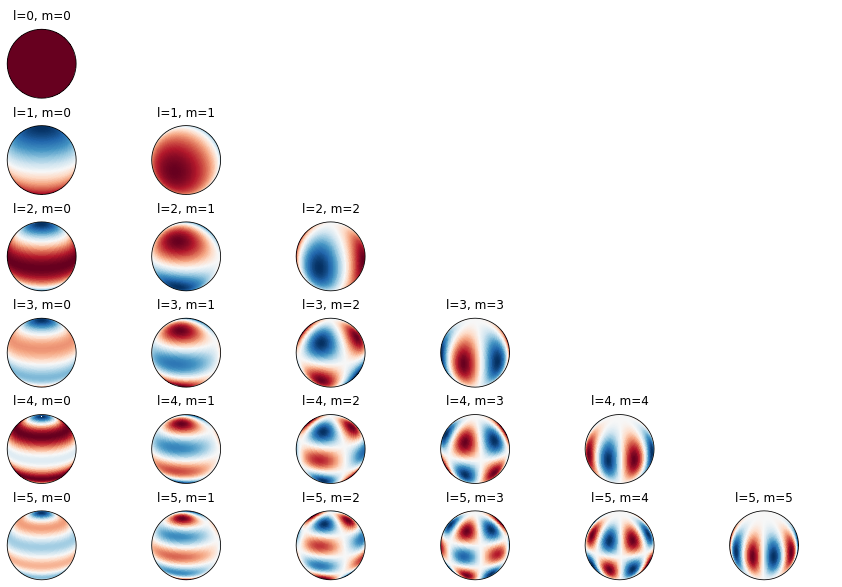

In [4]:
plt_lmax = 6

fig = plt.figure(layout='constrained', figsize=(12, 8))
subfigs = fig.subfigures(plt_lmax, plt_lmax)

for l in range(plt_lmax):
    for m in range(l+1):
        plot_sphere(vdm[midx(l,m)], fig=subfigs[l, m], title=f"l={l}, m={m}", lat=(lat - np.pi/2))

now, let us compute the gramian matrix $S^T \mathop{\mathrm{diag}}(\omega) S$:

In [5]:
gramian = torch.einsum("iqr,jqr,q->ij", vdm, vdm, omega)

In [6]:
# plt.pcolormesh(xlg, np.arange(0, nmodes), , cmap="plasma")
# plt.xlabel("x")
# plt.ylabel("l,m mode")
# plt.colorbar()

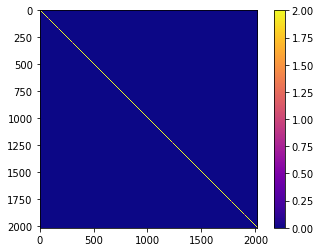

In [7]:
plt.imshow(gramian, interpolation="nearest", cmap="plasma")
plt.colorbar()

In [8]:
print(torch.max(gramian))
print(torch.argmax(gramian))
print(torch.min(gramian))
print(torch.argmin(gramian))

tensor(2.0000)
tensor(1536954)
tensor(-7.6013e-07)
tensor(1482353)


In [9]:
np.linalg.cond(gramian)

2.0000055

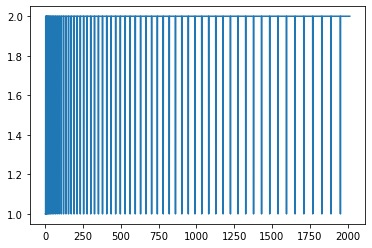

In [10]:
plt.plot(np.diag(gramian))